# Digit Recognizer

https://www.kaggle.com/c/digit-recognizer/overview

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data Loading

In [2]:
from fastai.vision import *

In [3]:
path = Config.data_path()/'digit-recognizer'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/digit-recognizer')

In [4]:
#! pip install kaggle --upgrade

In [5]:
#! rm {path}/*

#! kaggle competitions download -c digit-recognizer -p {path}
#! unzip -q -n {path}/digit-recognizer.zip -d {path}
#! rm {path}/*.zip

#path.ls()

In [6]:
df = pd.read_csv(path/'train.csv', header='infer')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
class NumpyImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28,1)
        return Image(pil2tensor(img, dtype=np.float32))
    
    @classmethod
    def from_csv(cls, path:PathOrStr, csv:str, **kwargs)->'ItemList': 
        df = pd.read_csv(Path(path)/csv, header='infer')
        res = super().from_df(df, path=path, cols=0, **kwargs)
        if 'label' in df.columns:
            df = df.drop('label', axis=1)
        df = np.array(df)/255.
#        mean = df.mean()
#        std = df.std()
#        res.items = (df-mean)/std
        res.items = df
        return res

In [8]:
test = NumpyImageList.from_csv(path, 'test.csv')
tfms = get_transforms(do_flip=False)
data = (NumpyImageList.from_csv(path, 'train.csv')
        .split_by_rand_pct(.1)
        .label_from_df(cols='label')
        .add_test(test, label=0)
        .transform(tfms)
        .databunch(bs=256, num_workers=0)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (37800 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,0,1,4,0
Path: /home/jupyter/.fastai/data/digit-recognizer;

Valid: LabelList (4200 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,6,1,1,4
Path: /home/jupyter/.fastai/data/digit-recognizer;

Test: LabelList (28000 items)
x: NumpyImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,0,0,0,0
Path: /home/jupyter/.fastai/data/digit-recognizer

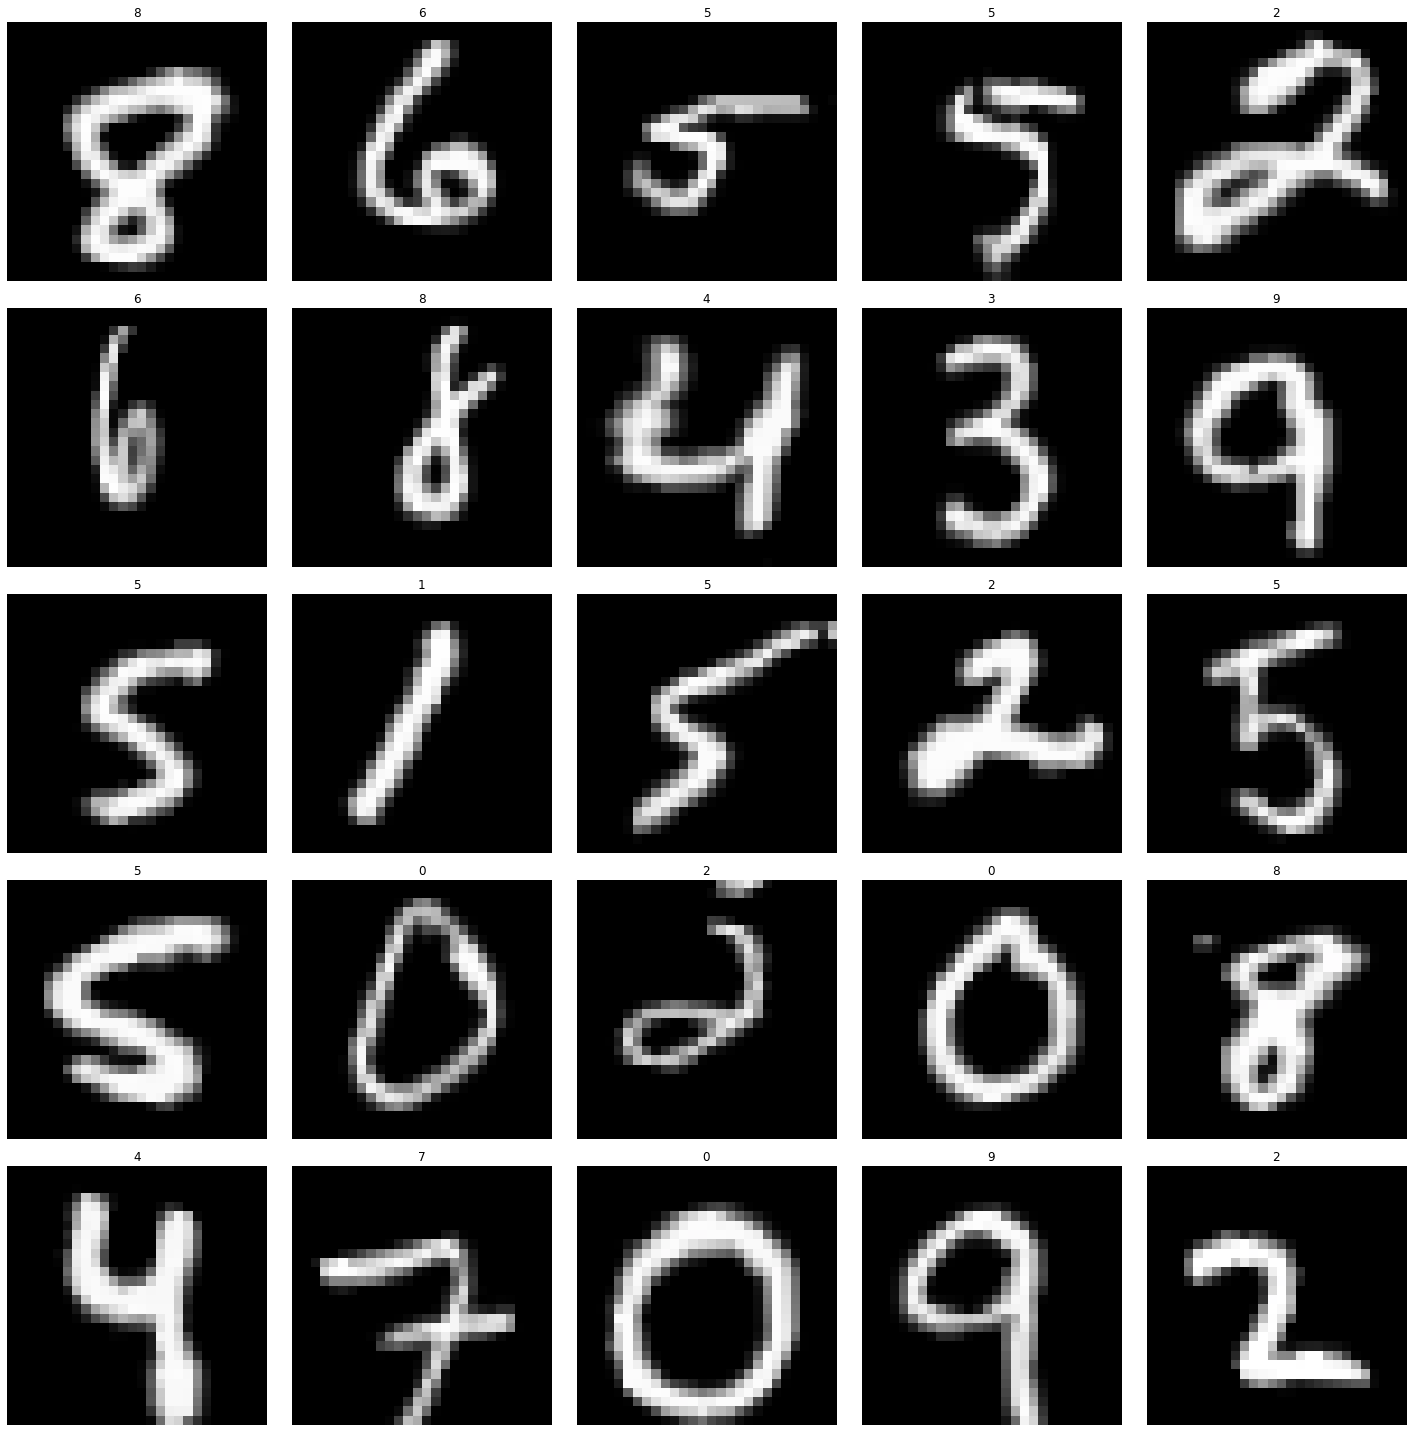

In [9]:
data.show_batch()

# Training

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


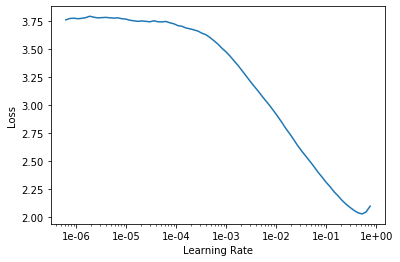

In [12]:
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.261768,0.697006,0.224048,00:47
1,0.651090,0.412717,0.141429,00:47
2,0.445312,0.304133,0.100952,00:47
3,0.385472,0.272953,0.087857,00:47


In [14]:
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


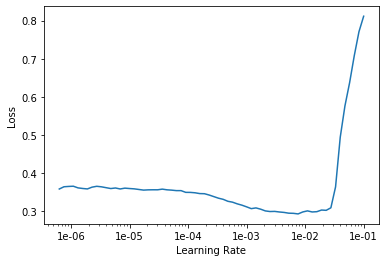

In [15]:
learn.load('stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, slice(1e-6, 2e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.271580,0.156712,0.049048,00:49
1,0.152317,0.097305,0.032857,00:49
2,0.105915,0.077094,0.026429,00:49
3,0.087702,0.072811,0.025952,00:49


In [17]:
learn.save('stage-2')

## Resnet50

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


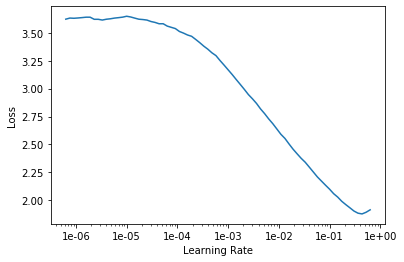

In [21]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.351519,0.923240,0.281905,00:50
1,0.859393,0.646861,0.188810,00:50
2,0.526943,0.385067,0.127857,00:50
3,0.353224,0.260167,0.084286,00:50
4,0.240206,0.166920,0.052857,00:49
5,0.198160,0.139068,0.041905,00:50
6,0.157730,0.114863,0.034524,00:50
7,0.140476,0.099465,0.031429,00:50
8,0.123929,0.097190,0.030952,00:50
9,0.121043,0.096593,0.032143,00:50


In [23]:
learn.save('stage-1-rn50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


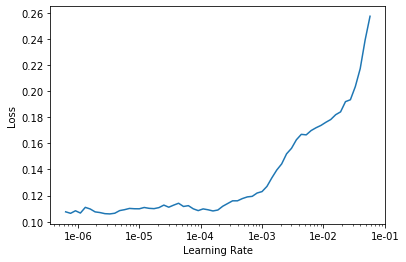

In [24]:
learn.load('stage-1-rn50')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.111441,0.093310,0.031429,00:52
1,0.107820,0.085812,0.029048,00:52
2,0.096311,0.072217,0.025238,00:52
3,0.080511,0.065415,0.021429,00:52
4,0.070028,0.057613,0.019048,00:52
5,0.061293,0.053582,0.017619,00:52
6,0.060534,0.050726,0.016429,00:52
7,0.053223,0.049743,0.016429,00:52
8,0.052553,0.048531,0.016190,00:52
9,0.051818,0.048377,0.016190,00:52


In [26]:
learn.save('stage-2-rn50')